Getting the data

In [4]:
# ! gdown --id 1nchhS4iewxjLY3zuFmymZAph5jqsZlkU #rat1
# ! gdown --id 1ULt0EacAB58zfGl-SY5TzkMaVVkyvn24 #rat1 dataset 2
# ! gdown --id 12SIMuoMLHEzEPhXaCn0aek483Dp3raYa #rat2
# ! gdown --id 1A2PcN-oYskxhQnT0JH8mDc-gFvPreMvI #rat3
# ! gdown --id 1b2i8lTYdgTe4bsTQanx2fZP3VHzXyrvc #rat4

Running setup

In [5]:
import numpy as np
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# from google.colab import drive
# drive.mount('/content/gdrive')

Which Rat

In [6]:
rat = 1

path = 'python_format/'
if rat == 1:
  path = path + 'moserlab_waaga_25843_2019-09-13_22-54-22_v1.npy'
elif rat == 11:
  path = path + 'moserlab_waaga_26018_2019-12-10_15-25-47_v1.npy'
elif rat == 2:
  path = path + 'moserlab_waaga_26018_2019-12-14_16-03-44_v1.npy'
elif rat == 3:
  path = path + 'moserlab_waaga_26718_2020-09-16_17-23-51_v1.npy'
elif rat == 4:
  path = path + 'moserlab_waaga_26820_2020-11-05_11-03-13_v1.npy'

dataset = np.load(path, allow_pickle=True)
data = dataset.item()

Initial Variables

In [7]:
speed_threshold = 0 #cm/sec, using speed greater than this



rounding = 0 #translates to arena resolution, 10^rounding
dr = 10**rounding
print(dr)
radius = 75 #radius of the area

L = 2*radius/dr+1
lim = radius
#Gaussian for tuning curves
sig = ((5)**2) #Gaussian Variance (cm^2)
sigma = np.array([[sig, 0],[0,sig]]) # Covariance Matrix

dt = -1 # when -1 dt is average time between two spikes ~0.008s, else dt is in seconds

1


Getting Speed and Speed Thresholding

In [8]:
Time = data['task'][1]['tracking']['t'] - data['task'][1]['tracking']['t'][0] #times scaled to start at 0
if dt == -1:
  dt = np.mean(Time[2:len(Time)-1] - Time[1:len(Time)-2])  # average interval between time points
#print(len(Time))
x = data['task'][1]['tracking']['x']
y = data['task'][1]['tracking']['y']

vx = np.gradient(x,dt) #could use the actual time differences, but using dt to sum
vy = np.gradient(y,dt)

V = np.sqrt((vx**2)+(vy**2))

speed = V
speed_idc = np.nonzero(speed>=speed_threshold)

x_Pos = x[speed_idc]
y_Pos = y[speed_idc]
Time = Time[speed_idc]

Building the Arena

In [9]:
#building the arena


X = np.linspace(-radius,radius,int(L))
Y = np.linspace(-radius,radius,int(L))
[X,Y] = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y 


# Early attempts to create out of bounds 
# r = np.sqrt(X**2+Y**2)
# R_sq = X**2 + Y**2

# r = np.sqrt(X**2+Y**2)
# R_sq = X**2 + Y**2


Generate Time Map

In [10]:
Time_map = np.zeros((int(L),int(L)))

# create one 3d array for X and Y

for k in range(len(Time)):
    gaussian = multivariate_normal(mean=[x_Pos[k],y_Pos[k]], cov=sigma)
    g_pdf = gaussian.pdf(pos)
    #Here they reshape the gaussian but seems uneccesary for python's gaussian
    Time_map = Time_map + g_pdf
    
#print(Time_map)

Get Spike Trains

In [11]:
Spike_times = data['task'][1]['spike_timestamp']  # times of very light spike
Spike_units = data['task'][1]['spike_cluster_id'] # corresponding cell that fired
Time = data['task'][1]['tracking']['t']

Time =  Time - Time[0]

Units = np.unique(Spike_units) # distinct cells that spike
N = len(Units) # number of cells


if dt == -1:
  dt = np.mean(Time[2:len(Time)-1] - Time[1:len(Time)-2]) # average interval between time points
Tp = len(Time) # number of time points or total time divided by window size
print(dt)
print(Tp)
print(len(Time))
print(Time[-1])

ST = np.zeros((N,int(Tp)+1)) # contains number of spikes for each neuron for each time bin +1 so last bin exists
#print(ST.shape)

for n in range(N): # for every neuron
    u = np.where(Spike_units==Units[n]) #indexes of spikes 
    st = Spike_times[u] #times of spikes for neuron n
    st = st - st[0] #this I added because the first spikes don't begin for so long that it doesn't fit in shape Tp
    #print(st)

    D = st/dt # D is the list of time bins for each spike of neuron n

    #print(D)
    # in matlab they set all bins labeled 0 to bin 1, not sure if necessary, only for spikes occuring before one full dt has passed
    
    for k in range(len(D)):
        x = int(D[k])
        #print(x)
        ST[n][x]=ST[n][x]+1

0.008336388232868228
436879
436879
3641.98459456443


Autocorrelation Function

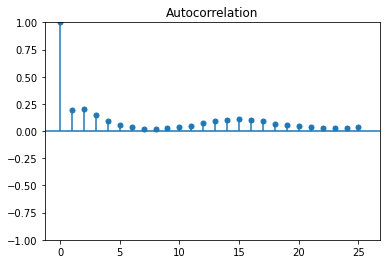

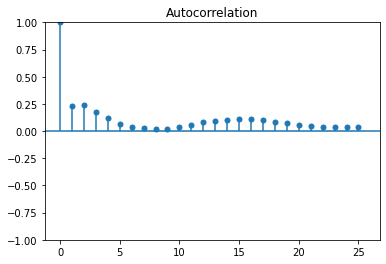

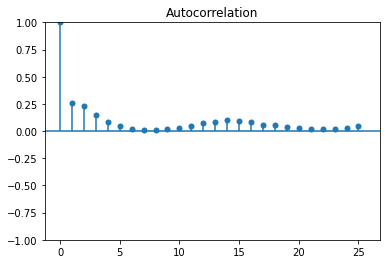

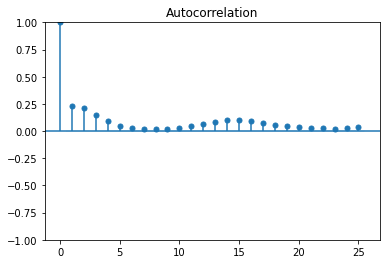

In [12]:
M1_indices = [3,8,9,10,12,21,23,25,30,33,35,36,39,40,41,43,44,165,168,181,184,185,186,187,188,191,195,197,201,204,205,208,210,211,213,214,215,216,217,221,222,224]

ST_M1 = ST[M1_indices,:]

for i in range(4):
    plot_acf(ST_M1[i,:], lags = 25)